# Clustering EnamineREAL hits from strategy B

## Aim of this notebook

Get divers set of compounds from EnamineREAL screening in strategy B.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem, DataStructs
from rdkit.Chem import PandasTools, rdFingerprintGenerator, Draw, rdFMCS
from rdkit.ML.Cluster import Butina

RDKit WARNING: [20:34:36] Enabling RDKit 2019.09.3 jupyter extensions


In [3]:
DATA_PATH = Path(_dh[0]) / '..' / '..' / 'data'
RESULTS_PATH = Path('.') / '..' / '..' / 'fragment_growing_pipeline' / 'result_data'

INPUT_DATA = DATA_PATH / 'compounds_enamine_real_strategy_b.smi'
OUTPUT_DATA = RESULTS_PATH / 'diverse_set_strategy_b.csv'

## Load molecule library

In [4]:
dataset = pd.read_csv(INPUT_DATA, header=None, names=['smiles'])
dataset.shape

(600, 1)

In [5]:
dataset

,smiles
0,[CH3][C](=[O])[NH][C@H]([CH2][C]1=[CH][CH]=[C]...
1,[CH3][C](=[O])[NH][C@H]([CH2][C]1=[CH][CH]=[C]...
2,[CH3][C](=[O])[NH][C@@H]([CH2][C]1=[CH][CH]=[C...
3,[CH3][C](=[O])[NH][C@H]([CH2][C]1=[CH][CH]=[C]...
4,[CH3][C](=[O])[NH][C@@H]([CH2][C]1=[CH][CH]=[C...
...,...
595,[CH3][CH2][O][C]1=[C]([CH2][N]([CH2][C@@H]([CH...
596,[CH3][C](=[O])[NH][C]1=[CH][NH][C](=[O])[C]([C...
597,[CH3][O][C](=[O])[C@H]([CH2][C]1=[C]([OH])[CH]...
598,[CH3][C@@]([OH])([CH2][NH][C](=[O])[NH][CH2][C...


In [6]:
PandasTools.AddMoleculeColumnToFrame(dataset, smilesCol='smiles')

## Generate fingerprints

In [7]:
rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

In [8]:
dataset['fingerprint'] = dataset.apply(lambda x: rdkit_gen.GetFingerprint(x.ROMol), axis=1)

## Cluster molecules (Butina algorithm)

Cluster molecules with different distance cutoffs - how many clusters come out?

In [9]:
def cluster_molecules(fingerprints, cutoff=0.6):
    """
    Cluster fingerprints using the Butina algorithm.
    
    Parameters
    ----------
    fingerprints : list of rdkit.DataStructs.cDataStructs.ExplicitBitVect
        List of fingerprints.
    cutoff : float
        Distance cutoff Butina clustering.
        
    Returns
    -------
    list of tuple of int
        List of clusters, whereby each cluster is described by its cluster member IDs.
    """
    
    # Calculate Tanimoto distance matrix
    distance_matrix = _tanimoto_distance_matrix(fingerprints)
    
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(
        distance_matrix,
        len(fingerprints),
        cutoff,
        isDistData=True
    )
    
    # Sort clusters by size
    clusters = sorted(clusters, key=len, reverse=True)
    
    return clusters

def _tanimoto_distance_matrix(fingerprints):
    """
    Calculate distance matrix for list of fingerprints.
    
    Parameters
    ----------
    fingerprints : list of rdkit.DataStructs.cDataStructs.ExplicitBitVect
        List of fingerprints.
        
    Returns
    -------
    list of floats
        Distance matrix (a triangular similarity matrix in the form of a list)
    """
    
    fingerprints = list(fingerprints)
    distance_matrix = []
    
    for i in range(1,len(fingerprints)):
        similarities = DataStructs.BulkTanimotoSimilarity(fingerprints[i], fingerprints[:i])
        
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        distance_matrix.extend([1-x for x in similarities])
    
    return distance_matrix

In [10]:
# Perform clustering with different distance cutoffs

cluster_by_cutoff = {}

for cutoff in np.arange(0.3, 0.45, 0.02):
    
    cutoff = round(cutoff, 2)
    
    clusters = cluster_molecules(dataset.fingerprint, cutoff)
    cluster_by_cutoff[cutoff] = clusters

## Get clustering stats (per distance cutoff)

Use these statistics to decide on distance cutoff.

In [11]:
pd.DataFrame(
    [(cutoff, len([cluster for cluster in clusters if len(cluster)>0])) for cutoff, clusters in cluster_by_cutoff.items()],
    columns=['cutoff', '#Clusters/size>1']
)

,cutoff,#Clusters/size>1
0,0.30,184
1,0.32,164
2,0.34,151
3,0.36,133
4,0.38,123
5,0.40,105
6,0.42,93
7,0.44,79


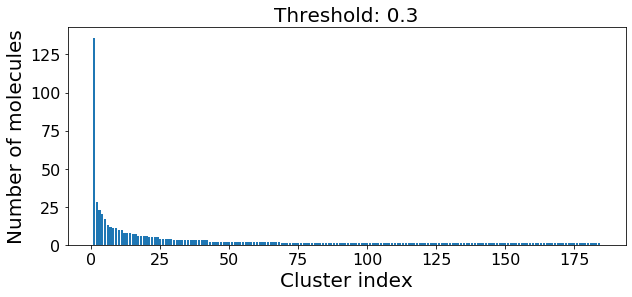

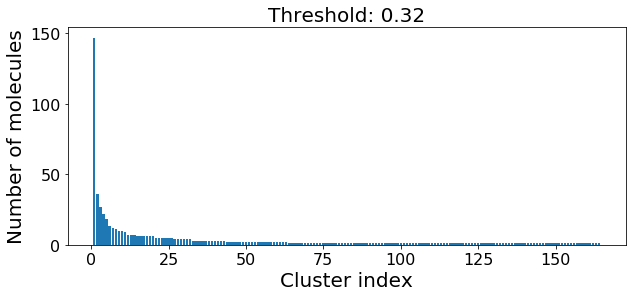

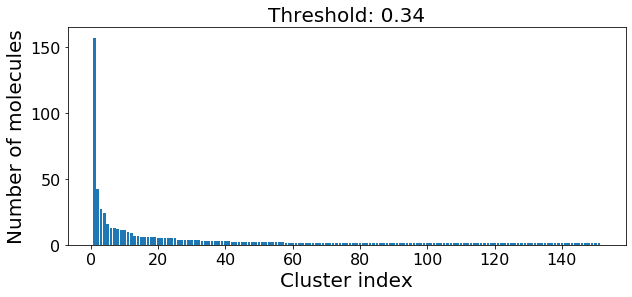

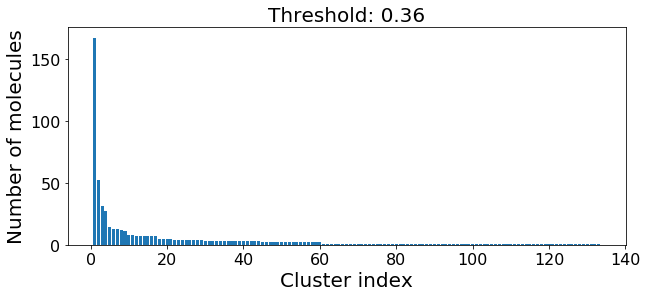

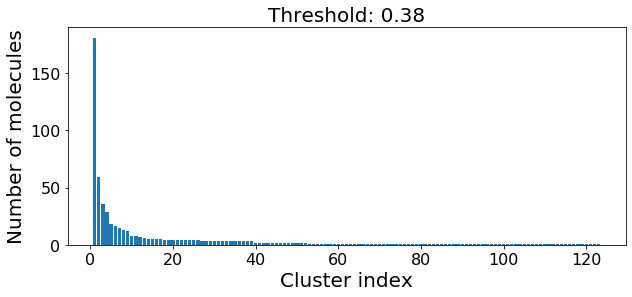

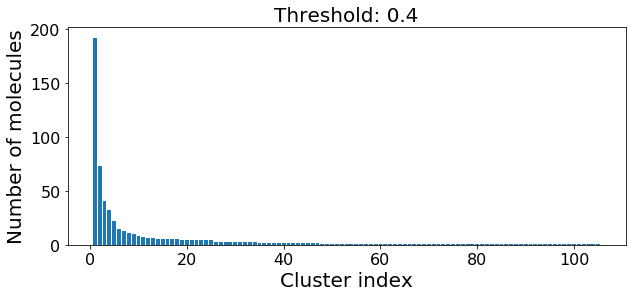

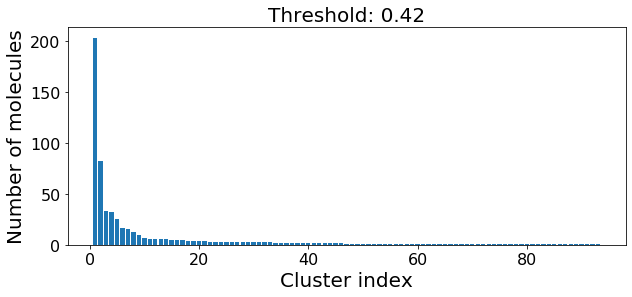

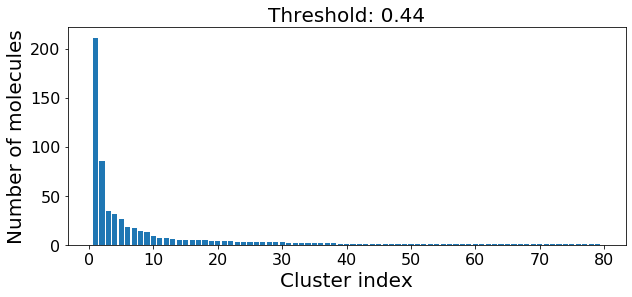

In [12]:
for cutoff, clusters in cluster_by_cutoff.items():
    
    fig = plt.figure(1, figsize=(10, 4))
    plt1 = plt.subplot(111)
    #plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title(f'Threshold: {cutoff}', fontsize=20)
    plt.bar(range(1, len(clusters)+1), [len(cluster) for cluster in clusters], lw=0)
    plt.show()

## Choose cluster distance cutoff

Select distance cutoff, where 100 clusters without clusters with sizes 1 and 2.

In [13]:
DISTANCE_CUTOFF = 0.4

In [14]:
# Choose clustering and select first 100 (largest cluster)
selected_clustering = cluster_by_cutoff[DISTANCE_CUTOFF][:100]

In [15]:
len(selected_clustering)

100

## Draw clusters

This function allows you to draw each cluster of a clustering based on a selected distance cutoff.

In [16]:
def highlight_mcs(mols, mcs_threshold=0.8):
    
    mcs = rdFMCS.FindMCS(mols, threshold=mcs_threshold)
    
    pattern = Chem.MolFromSmarts(mcs.smartsString)
    mcs_matches = [mol.GetSubstructMatch(pattern) for mol in mols]
    
    return mcs_matches

In [17]:
def draw_clusters(mols, clusters, max_mols=1000):
    """
    Draw molecules sorted by descending cluster size.
    
    Parameters
    ----------
    mols : list of rdkit.Chem.rdchem.Mol
        Molecules.
    clusters : list of tuple of int
        List of clusters, whereby each cluster is described by its cluster member IDs.
    max_mols : int
        Number of molecules shown per cluster ID (default 1000).
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Molecules for each cluster (legend = "cluster ID | molecule ID").
    """
    
    clustered_mols = []
    legends = []
    
    for cluster_id, cluster in enumerate(clusters):
        
        clustered_mols.extend([mols[mol_id] for mol_id in cluster])
        legends.extend([f'{cluster_id+1} | {mol_id}' for mol_id in cluster])
        
    img = Draw.MolsToGridImage(
        clustered_mols, 
        legends=legends, 
        molsPerRow=6, 
        maxMols=max_mols, 
        #highlightAtomLists=highlight_mcs(clustered_mols, mcs_threshold=0.8)
    )
        
    return img

In [18]:
img = draw_clusters(dataset.ROMol, selected_clustering, max_mols=1000)

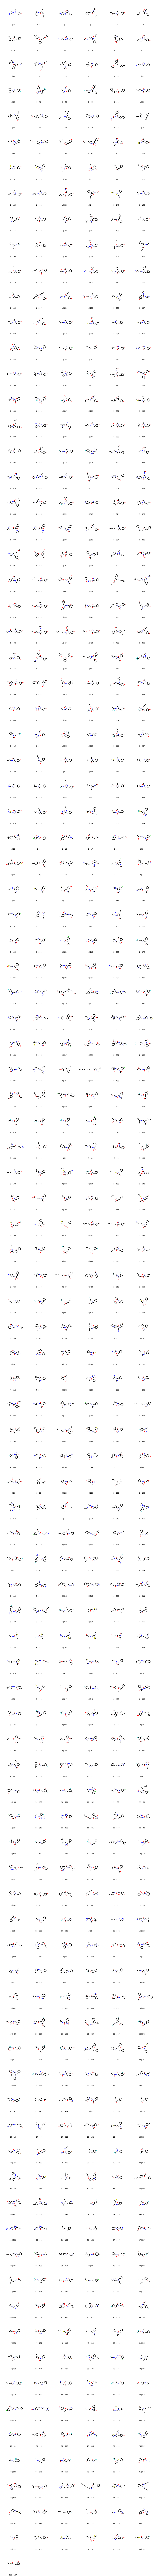

In [19]:
img

## Get cluster centroids

First molecule in each cluster is cluster centroid - thus, extract first molecule per cluster!

In [20]:
cluster_centroids = [cluster[0] for cluster in selected_clustering]

In [21]:
len(cluster_centroids)

100

In [22]:
def draw_cluster_centroids(mols, cluster_centroids, max_mols=100):
    """
    Draw fragments sorted by descending cluster size.
    
    Parameters
    ----------
    mols : list of rdkit.Chem.rdchem.Mol
        List of top x fragments.
    cluster_centroids : list of int
        List of cluster centroids (their molecule IDs).
    
    Returns
    -------
    PIL.PngImagePlugin.PngImageFile
        Image of cluster centroids (legend = "cluster ID | molecule ID").
    """
    
    cluster_centroids_mols = []
    legends = []
    
    for cluster_id, molecule_id in enumerate(cluster_centroids):
        
        cluster_centroids_mols.append(mols[molecule_id])
        legends.append(f'{cluster_id+1} | {molecule_id}')
        
    img = Draw.MolsToGridImage(cluster_centroids_mols, legends=legends,  molsPerRow=6, maxMols=max_mols)
    
    return img

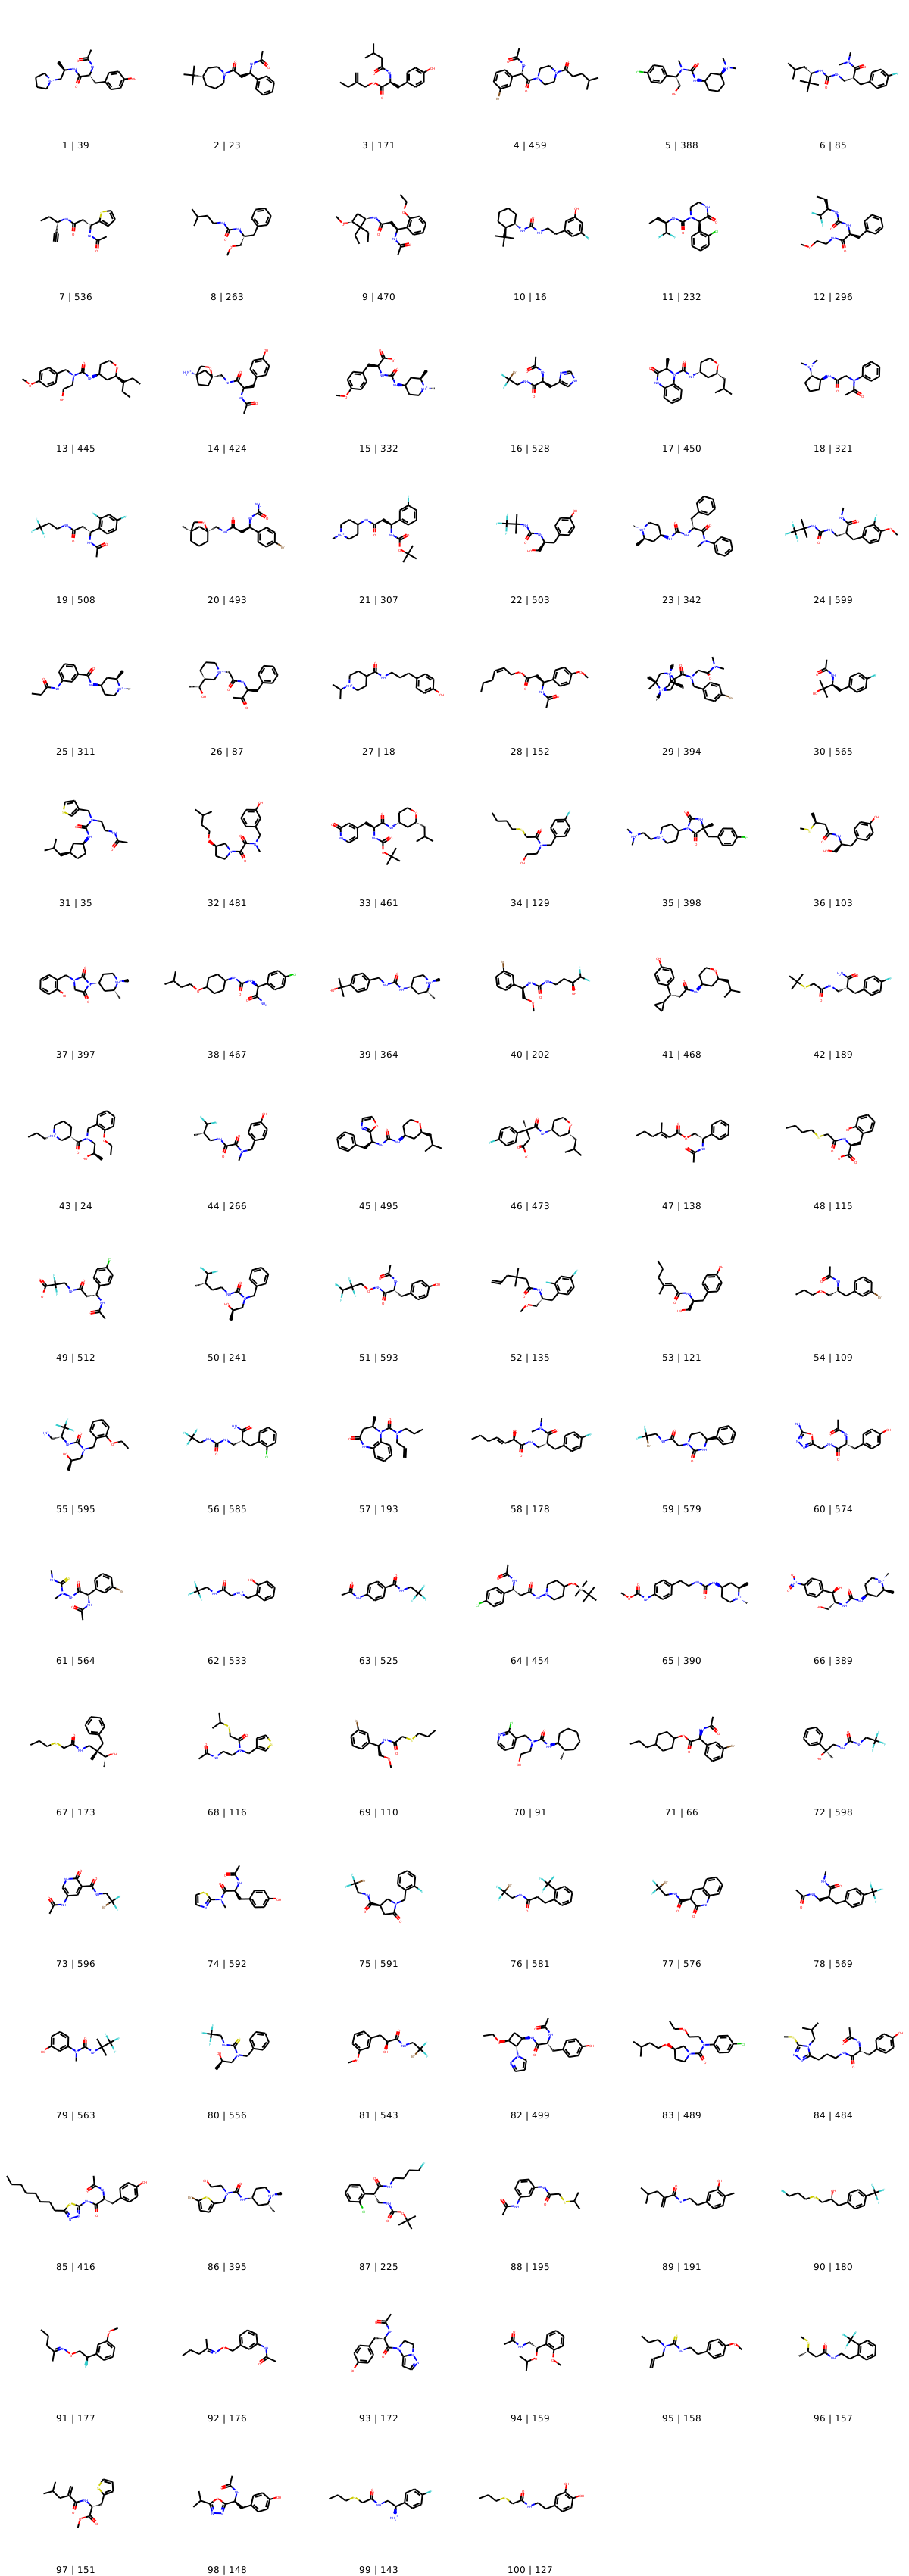

In [23]:
draw_cluster_centroids(dataset.ROMol, cluster_centroids)

## Save diverse compounds set to file

,smiles,ROMol,fingerprint
39,[CH3][C](=[O])[NH][C@H]([CH2][C]1=[CH][CH]=[C]...,,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
23,[CH3][C](=[O])[NH][C@H]([CH2][C](=[O])[N]1[CH2...,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
171,[CH2]=[C]([CH2][CH3])[CH2][O][C](=[O])[C@H]([C...,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
459,[CH3][C](=[O])[NH][C@H]([C](=[O])[N]1[CH2][CH2...,,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
388,[CH3][N]([C](=[O])[NH][C@@H]1[CH2][CH2][CH2][C...,,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."

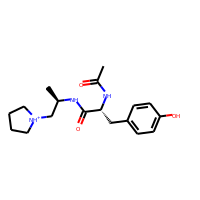
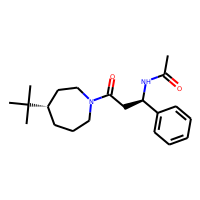
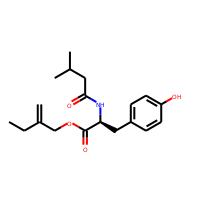
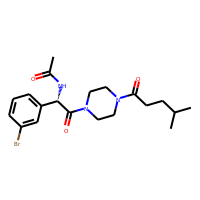
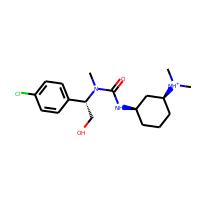

In [24]:
dataset.iloc[cluster_centroids].head()

In [25]:
print(f'Number of moleules in diverse set: {dataset.iloc[cluster_centroids].shape[0]}')

Number of moleules in diverse set: 100


In [26]:
dataset.iloc[cluster_centroids]['smiles'].to_csv(OUTPUT_DATA, index=None, header=None)